This code is for analysis of the ColabFold-PDB complexes.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots


ModuleNotFoundError: No module named 'scienceplots'

We want to find the ColabFold and experimental structures that most closely match for every protein in their active and autoinhibited states.

In [2]:
'''
For some reason, all of P62826's "state" data is missing, so we have to correct that here.
'''

df = pd.read_csv('./project_pipeline/data/cf_pdb_compared.tsv', sep='\t').astype('object')
df2 = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

df = df.drop(columns=['state', 'conformation'])

df2 = df2[['uniprot', 'pdb', 'state', 'conformation', 'organism']]

df = df.merge(df2, how='left', on=['uniprot', 'pdb'])

df.head()

NameError: name 'pd' is not defined

,state,uniprot,pdb,2_comp,conformation,cluster
0,Active,O08967,6bbp,32.391,Open,U10-000
1,Active,O60741,5u6p,23.067,Closed,U100-000
2,Active,P07038,1mhs,20.955,Open,U100-000
3,Active,P12931,1y57,34.052,Open,001
4,Active,P21333,4p3w,44.967,Open,U10-000
5,Active,P22681,4a49,12.380,Open,004
6,Active,P26358,3swr,41.304,Open,U100-000
7,Active,P27577,1md0,14.384,Open,U100-000
8,Active,P28482,4qp2,3.372,Open,003
9,Active,P29350,3ps5,2.867,Open,U100-000


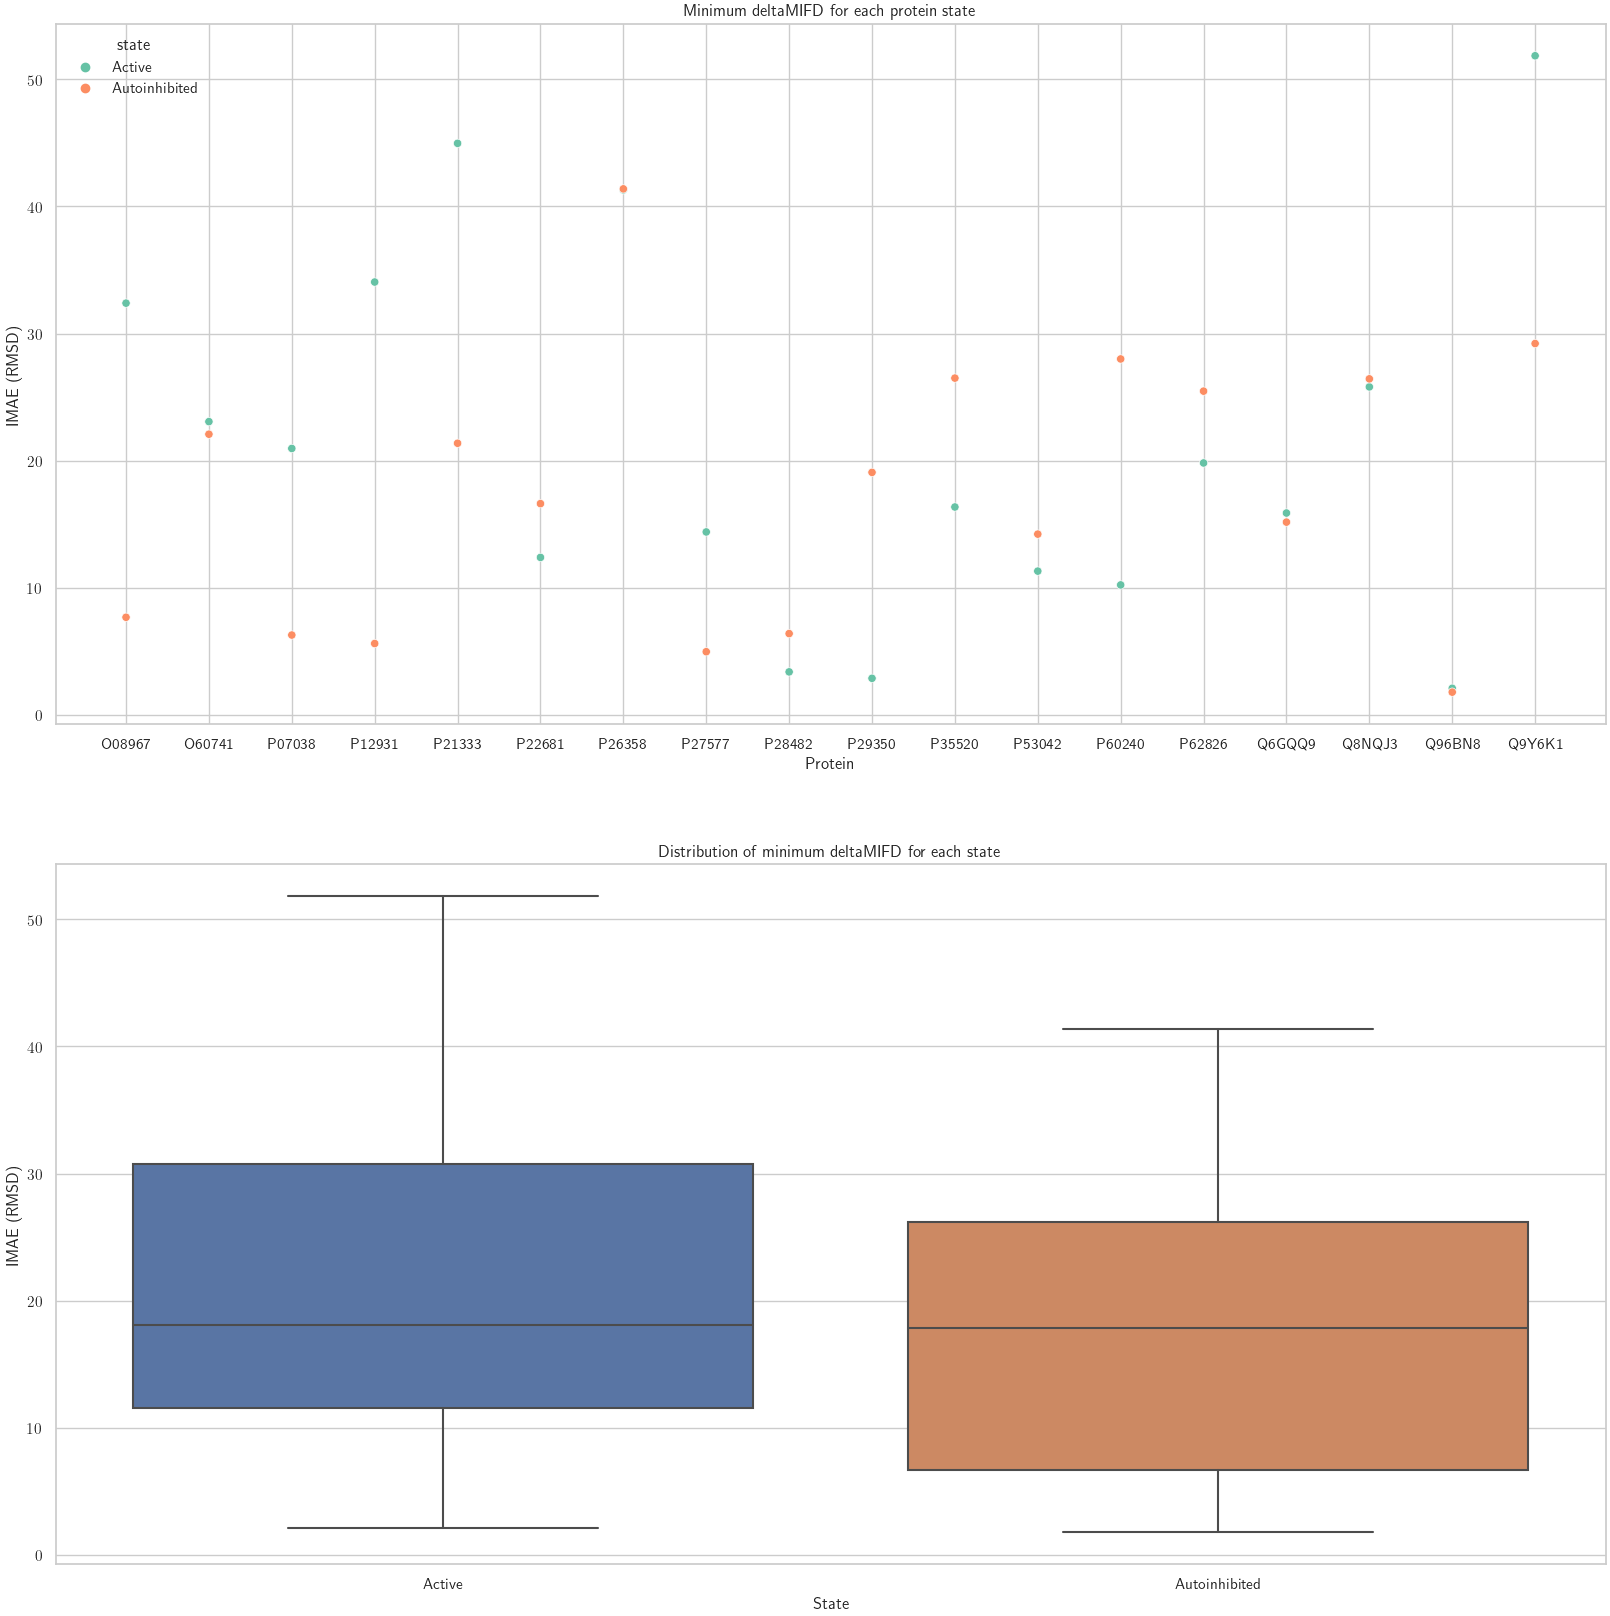

<Figure size 1000x600 with 0 Axes>

In [90]:
'''
With our dataframe corrected, we can now proceed with the analysis.
'''
plt.style.use('science')

# Drop state and conformation rows with missing values
df = df.dropna(subset=['state', 'conformation']).reset_index(drop=True)

# Convert columns to numeric
df['2_comp'] = pd.to_numeric(df['2_comp'], errors='coerce')

# Group by state and protein and find the minimum 2_comp for each group
df_min = df.groupby(['state', 'uniprot', 'pdb']).agg({'2_comp': 'min'}).reset_index()

df_clust = df[['uniprot', 'pdb', '2_comp', 'state', 'conformation', 'cluster']]

df3 = df_min.merge(df_clust, how='left', on=['uniprot', '2_comp', 'state', 'pdb']).drop_duplicates(subset=['uniprot', 'state'], keep='first').reset_index(drop=True)

# Plot the minimum 2_comp for each state
sns.set(style='whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
sns.scatterplot(x='uniprot', y='2_comp', data=df3, hue='state', ax=ax[0], palette='Set2')
ax[0].set_title('Minimum deltaMIFD for each protein state')
ax[0].set_xlabel('Protein')
ax[0].set_ylabel('IMAE (RMSD)')

# Plot a boxplot of the distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='state', y='2_comp', data=df3, ax=ax[1])
ax[1].set_title('Distribution of minimum deltaMIFD for each state')
ax[1].set_xlabel('State')
ax[1].set_ylabel('IMAE (RMSD)')

df3.head(40)

Text(0, 0.5, 'IMAE (RMSD)')

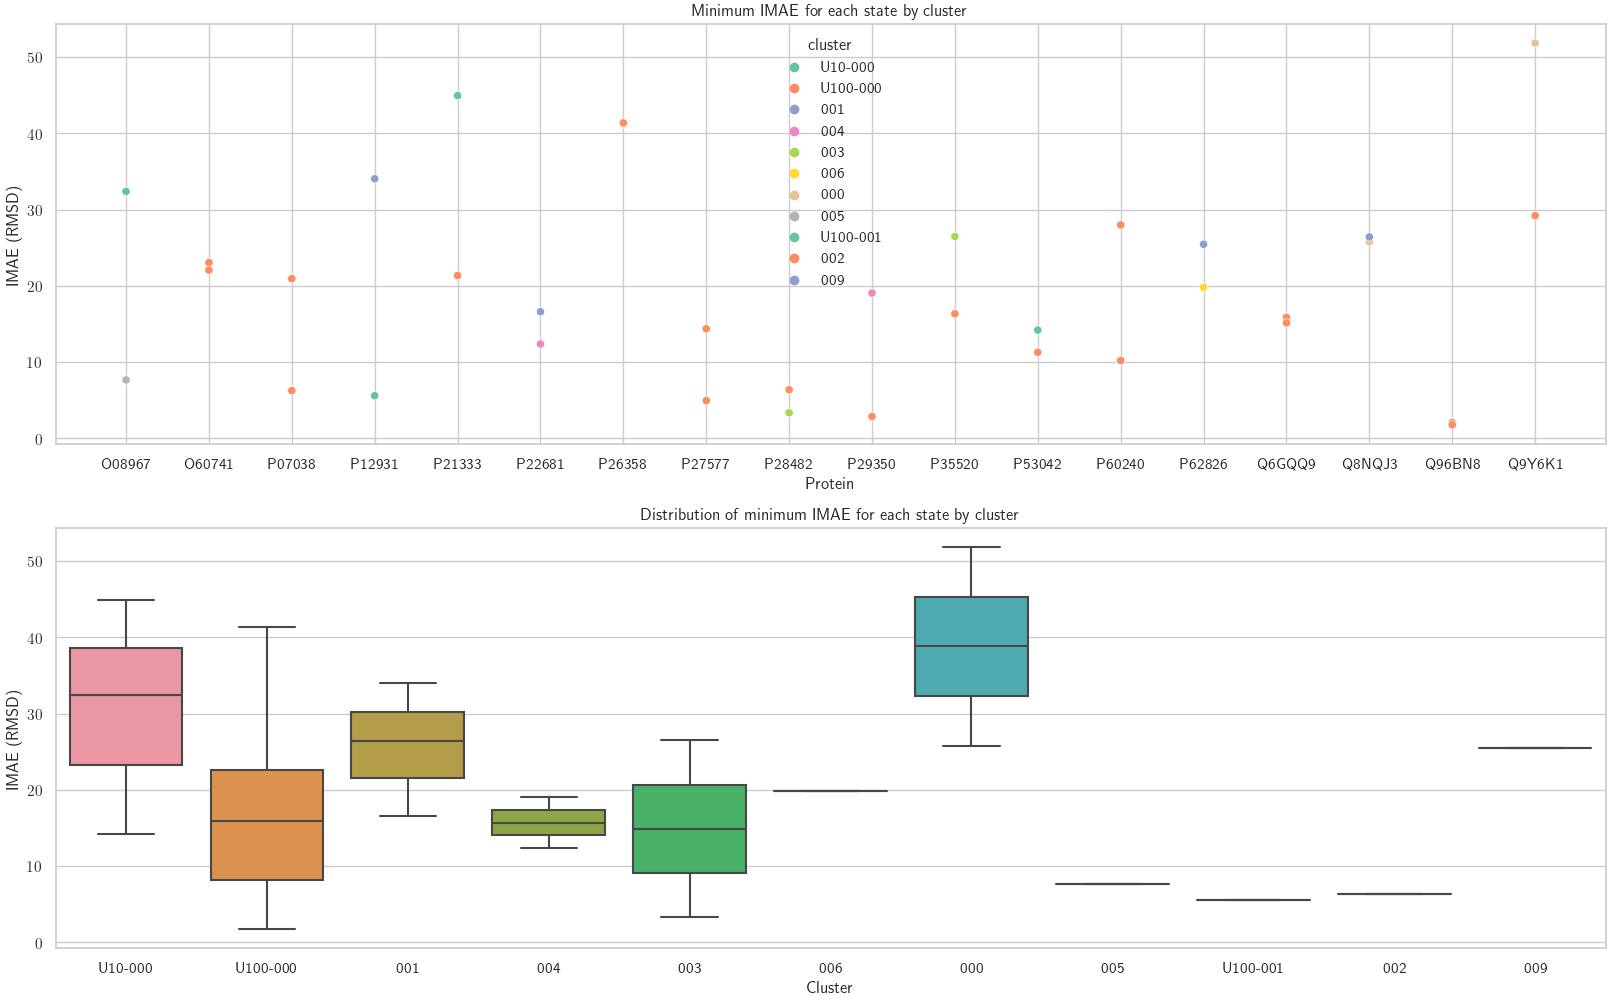

In [98]:
# Show a scatterplot by cluster
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
sns.scatterplot(x='uniprot', y='2_comp', data=df3, hue='cluster', palette='Set2', ax=ax[0])
ax[0].set_title('Minimum IMAE for each state by cluster')
ax[0].set_xlabel('Protein')
ax[0].set_ylabel('IMAE (RMSD)')

clusters = df3['cluster'].value_counts().reset_index()

#Let's make a boxplot by cluster
sns.boxplot(x='cluster', y='2_comp', data=df3, ax=ax[1])
ax[1].set_title('Distribution of minimum IMAE for each state by cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('IMAE (RMSD)')

# medians = df3.groupby('cluster')['2_comp'].median().values
# nobs = df3['cluster'].value_counts().values
# nobs = [str(x) for x in nobs.tolist()]
# nobs = ['n: ' + i for i in nobs]

# pos = range(len(nobs))
# for tick, label in zip(pos,ax[1].get_xticklabels()):
#     ax[1].text(pos[tick],
#             medians[tick] + 0.03,
#             nobs[tick],
#             horizontalalignment='center',
#             size='small',
#             color='black',
#             weight='semibold')